In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

from matplotlib import cm
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from feature_processing import (create_contingency_table,
                                calculate_conditional_prob_bin,
                                encode_my_categorical_labels,
                                calculate_conditional_prob_cat,
                                estimate_cond_prob_density,
                                bin_myFeature)

/home/ryohayama/.local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Import Data

In [2]:
train = pd.read_csv('train.csv', header=0)

In [3]:
# Get different kinds of features
all_fs = train.columns[:-1]
binary_fs = sorted([f for f in all_fs if '_bin' in f])
categorical_fs = sorted([f for f in all_fs if '_cat' in f])
other_fs = sorted([f for f in all_fs
            if f not in binary_fs
            if f not in categorical_fs])

print("# total of features: %8d" % len(all_fs))
print("# of binary features: %7d" % len(binary_fs))
print("# of categorical features: %1d" % len(categorical_fs))
print("# of other features: %8d" % len(other_fs))

# total of features:       58
# of binary features:      16
# of categorical features: 14
# of other features:       28


In [4]:
categoricals = train[categorical_fs]

In [5]:
for f in categorical_fs:
    print('%s: # unique values: %d' % (f, len(categoricals[f].unique())))

ps_car_01_cat: # unique values: 13
ps_car_02_cat: # unique values: 3
ps_car_03_cat: # unique values: 3
ps_car_04_cat: # unique values: 10
ps_car_05_cat: # unique values: 3
ps_car_06_cat: # unique values: 18
ps_car_07_cat: # unique values: 3
ps_car_08_cat: # unique values: 2
ps_car_09_cat: # unique values: 6
ps_car_10_cat: # unique values: 3
ps_car_11_cat: # unique values: 104
ps_ind_02_cat: # unique values: 5
ps_ind_04_cat: # unique values: 3
ps_ind_05_cat: # unique values: 8


# Calculate Frequency of Class1

In [6]:
target = train['target']
total = len(target)
num_class1 = np.sum(target)
class1_frequency = num_class1/total
print('Frequency of Class1=%f' % class1_frequency)

Frequency of Class1=0.036448


# Write a function to analyze join probability of two categorical features
Things to calculate/plot
- Take in two features with m and n possible values respectively, including missing value as a category
- Calculate P(Class1|value=x) for each feature (total m and cond. probas respectively)
- Calculate co-occurence of feature values (i.e get contingency table)
- Calculate chi statistic/p-value
- For each combination of values (there are m x n combos), calculate P(Class|combo)
- Assess if max(joint probas) is bigger than max(individual cond. probas)

In [32]:
from feature_analysis import BinaryComparison, CategoricalComparison, assess_feature_frequency

### Test the function

In [8]:
# Test case
f1 = categoricals.iloc[:, 0]
f2 = categoricals.iloc[:, 1]
target = train['target']

In [9]:
cc = CategoricalComparison(f1, f2, target)

In [10]:
cc.category_values_

{'ps_car_01_cat': array([10, 11,  7,  6,  9,  5,  4,  8,  3,  0,  2,  1, -1]),
 'ps_car_02_cat': array([ 1,  0, -1])}

In [11]:
cc.num_category_values_

{'ps_car_01_cat': 13, 'ps_car_02_cat': 3}

In [12]:
cc.contingency_table_

ps_car_02_cat,-1,0,1
ps_car_01_cat,,,
-1,0,23,84
0,0,890,5014
1,0,169,1198
2,0,234,1910
3,0,723,5935
4,0,3520,22654
5,0,1646,16496
6,0,7928,54465
7,3,17070,162174


In [13]:
cc.test_independence()

Feature association is significant (p-value=0.000)


In [14]:
ind_probas = cc.calculate_individual_probas()
ind_probas['probas']

,ps_car_01_cat_probas,ps_car_02_cat_probas
11,0.041581,NaN
7,0.028770,NaN
6,0.029763,NaN
10,0.036976,NaN
4,0.039161,NaN
9,0.054421,NaN
5,0.039246,NaN
8,0.043398,NaN
3,0.037549,NaN
0,0.043869,0.049507


In [15]:
ind_probas['probas'].replace({np.NaN: 0}).values.max()

0.31775700934579437

In [16]:
cc.calculate_join_probas()

ps_car_02_cat,-1,0,1
ps_car_01_cat,,,
-1,NaN,0.478261,0.273810
0,NaN,0.052809,0.042282
1,NaN,0.059172,0.045075
2,NaN,0.038462,0.043455
3,NaN,0.047026,0.036394
4,NaN,0.048864,0.037653
5,NaN,0.056501,0.037524
6,NaN,0.034687,0.029046
7,NaN,0.043937,0.027175


In [17]:
cc.calculate_join_probas().replace({np.NaN: 0}).values.max()

0.47826086956521741

In [18]:
cc.assess_joint_result()

1.5051150895140666

# Pairwise Analysis of All Categorical Features

In [19]:
%%time
target = train['target']
num_categorical_fs = len(categorical_fs)
gain_table = np.zeros((num_categorical_fs, num_categorical_fs))
pval_table = np.zeros((num_categorical_fs, num_categorical_fs))

for i in range(num_categorical_fs-1):
    for j in range(i+1, num_categorical_fs):
        feature1 = categoricals.iloc[:, i]
        feature2 = categoricals.iloc[:, j]
        cc = CategoricalComparison(feature1, feature2, target)
        gain = cc.assess_joint_result(mode='ratio')
        gain_table[i, j] = gain - 1
        gain_table[j, i] = gain - 1
        
        pval = cc.chi_pvalue_
        pval_table[i, j] = pval
        pval_table[j, i] = pval
        
gain_table = pd.DataFrame(gain_table, columns=categorical_fs, index=categorical_fs)
pval_table = pd.DataFrame(pval_table, columns=categorical_fs, index=categorical_fs)

CPU times: user 8.87 s, sys: 889 ms, total: 9.76 s
Wall time: 9.79 s


Heatmap for the independence/association test among binary features.
Higher p-value indicates higher independence between features.


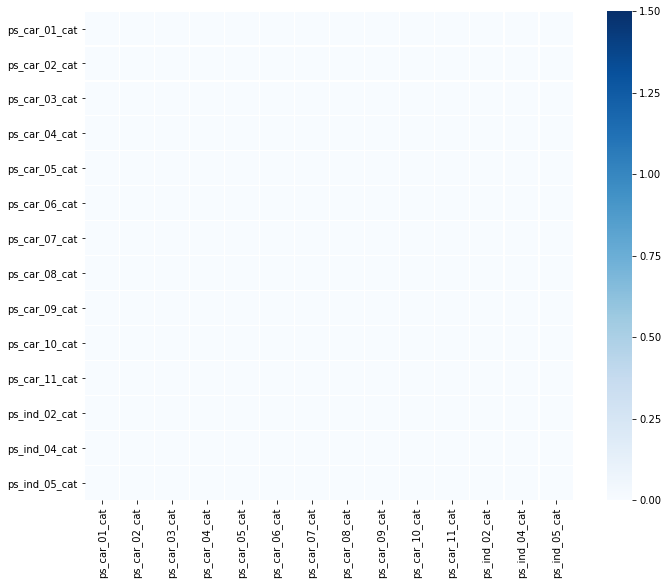

In [20]:
plt.figure(figsize=(12,9))
sns.heatmap(pval_table, linewidths=0.2, vmax=1.5, square=True, 
            cmap=cm.Blues, linecolor='white', annot=False)
print('Heatmap for the independence/association test among binary features.')
print('Higher p-value indicates higher independence between features.')

There is a high degree of association among features. The result may or may not be different if missing values were excluded from the analysis

Heatmap for gain in joint probability.
Higher gain indicates higher discriminatory power by joint.


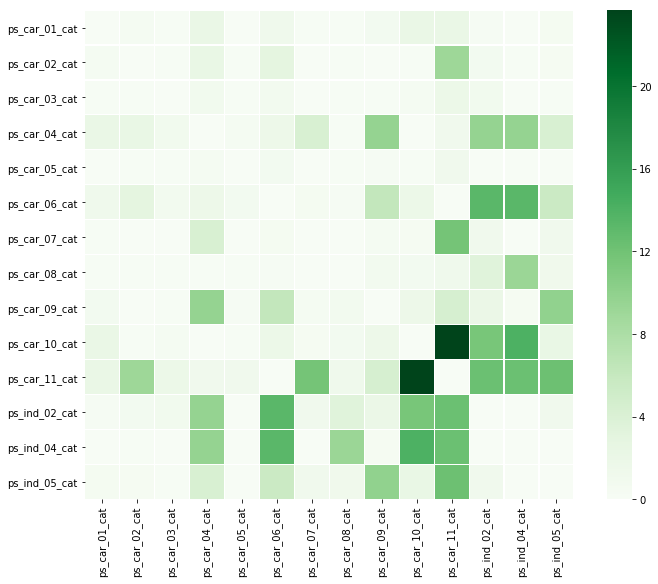

In [21]:
plt.figure(figsize=(12,9))
sns.heatmap(gain_table, linewidths=0.2, square=True, #vmax=1.5,
            cmap=cm.Greens, linecolor='white', annot=False)
print('Heatmap for gain in joint probability.')
print('Higher gain indicates higher discriminatory power by joint.')

Check the following pairs manually<br>
()

<b>car10 and car11</b>

In [22]:
cc_car10_car11 = CategoricalComparison(categoricals['ps_car_11_cat'], categoricals['ps_car_10_cat'], target)
cc_car10_car11.calculate_join_probas()

ps_car_10_cat,0,1,2
ps_car_11_cat,,,
1,0.037037,0.040557,NaN
2,0.037037,0.038005,NaN
3,0.083333,0.051056,NaN
4,0.000000,0.060815,NaN
5,0.050000,0.041918,NaN
6,0.000000,0.037217,NaN
7,0.022599,0.025566,NaN
8,0.000000,0.037515,NaN
9,0.000000,0.028156,NaN


In [23]:
cc_car10_car11.calculate_individual_probas()['probas']

,ps_car_11_cat_probas,ps_car_10_cat_probas
104,0.045015,NaN
103,0.026667,NaN
64,0.028728,NaN
87,0.031626,NaN
32,0.024328,NaN
28,0.042431,NaN
5,0.041956,NaN
99,0.023003,NaN
65,0.030628,NaN
82,0.026266,NaN


In [24]:
cc_car10_car11.assess_joint_result(printout=True)

Max Individual Probability=0.075110
Max Joint Probability=1.000000


13.313807531380755

In [25]:
train[(train['ps_car_11_cat'] == 93) & (train['ps_car_10_cat'] == 0)]

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
217915,544416,1,0,2,1,0,-1,1,0,0,...,7,2,3,6,0,1,0,0,1,0


<b>car04 and ind02</b>

In [26]:
cc_car04_ind02 = CategoricalComparison(categoricals['ps_car_04_cat'], categoricals['ps_ind_02_cat'], target)
cc_car04_ind02.calculate_join_probas()

ps_ind_02_cat,-1,1,2,3,4
ps_car_04_cat,,,,,
0,0.093525,0.032303,0.036443,0.034964,0.036763
1,0.333333,0.047860,0.051319,0.043923,0.066922
2,0.428571,0.046874,0.047809,0.039490,0.037383
3,NaN,0.044693,0.101449,0.037037,0.142857
4,NaN,0.013889,0.025974,0.000000,0.250000
5,1.000000,0.060302,0.078431,0.142857,0.111111
6,0.500000,0.056240,0.063158,0.078431,0.105263
7,NaN,0.092437,0.111111,0.000000,NaN
8,0.076923,0.049159,0.053983,0.048684,0.092308


In [27]:
cc_car04_ind02.calculate_individual_probas()['probas']

,ps_car_04_cat_probas,ps_ind_02_cat_probas
0,0.033451,NaN
1,0.048825,0.035725
2,0.047202,0.038139
8,0.050151,NaN
9,0.061889,NaN
6,0.058974,NaN
3,0.051562,0.037217
5,0.071560,NaN
4,0.021739,0.040780
7,0.093525,NaN


In [28]:
cc_car04_ind02.assess_joint_result(printout=True)

Max Individual Probability=0.093525
Max Joint Probability=1.000000


10.692307692307692

In [29]:
cc_car04_ind04 = CategoricalComparison(categoricals['ps_car_04_cat'], categoricals['ps_ind_04_cat'], target)
cc_car04_ind04.calculate_join_probas()

ps_ind_04_cat,-1,0,1
ps_car_04_cat,,,
0,0.222222,0.031118,0.036497
1,0.800000,0.049138,0.048167
2,0.468750,0.046520,0.047193
3,NaN,0.046154,0.057143
4,NaN,0.020305,0.030303
5,1.000000,0.075949,0.053691
6,1.000000,0.056318,0.074713
7,NaN,0.104839,0.000000
8,0.142857,0.048197,0.053987


In [30]:
cc_car04_ind04.calculate_individual_probas()['probas']

,ps_car_04_cat_probas,ps_ind_04_cat_probas
0,0.033451,0.034790
1,0.048825,0.038644
2,0.047202,NaN
8,0.050151,NaN
9,0.061889,NaN
6,0.058974,NaN
3,0.051562,NaN
5,0.071560,NaN
4,0.021739,NaN
7,0.093525,NaN


In [31]:
cc_car04_ind04.assess_joint_result(printout=True)

Max Individual Probability=0.093525
Max Joint Probability=1.000000


10.692307692307692

# Fusing Features Based on Joint Probabilities

In [ ]:
categorical_fs

fuse_pairs = [()]

### ind09-ind10

In [ ]:
bc_ind09_ind10 = BinaryComparison(binaries['ps_ind_09_bin'], binaries['ps_ind_10_bin'], target)
bc_ind09_ind10.calculate_join_probas()

In [ ]:
vec1 = bc_ind09_ind10.features
vec1['ind09_ind10_fusion'] = 0
vec1['ind09_ind10_fusion'][(vec1['ps_ind_09_bin'] == 0) & (vec1['ps_ind_10_bin'] == 1)] = 1
vec1['ind09_ind10_fusion'][(vec1['ps_ind_09_bin'] == 1) & (vec1['ps_ind_10_bin'] == 1)] = 2
ind09_ind10_fusion = vec1['ind09_ind10_fusion']

<b>Fuse the features</b>

In [ ]:
fuse1 = ['ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_calc_18_bin', 
         'ps_ind_13_bin', 'ps_ind_17_bin', 'ps_ind_07_bin', 'ps_ind_12_bin',
         'ps_ind_08_bin', 'ps_ind_16_bin']
nonfuse1 = [f for f in binary_fs if f not in fuse1]
nonfuse_features1 = binaries[nonfuse1]

In [ ]:
fusion1_1 = encode_my_categorical_labels(ind09_ind10_fusion)
fusion1_2 = encode_my_categorical_labels(ind13_ind17_fusion)
fusion1_3 = encode_my_categorical_labels(ind07_ind12_fusion)

In [ ]:
fused_binaries1 = pd.concat([nonfuse_features1, fusion1_1, fusion1_2, fusion1_3, 
                             ind11_calc18_fusion, ind08_ind16_fusion], axis=1)

In [ ]:
fused_binaries1.head(5)

# Pairwise Analysis of Newly Fused Categorical Features

In [ ]:
%%time
target = train['target']
num_fs = len(fused_binaries1.columns)
gain_table2 = np.zeros((num_fs, num_fs))
pval_table2 = np.zeros((num_fs, num_fs))

for i in range(num_fs-1):
    for j in range(i+1, num_fs):
        feature1 = fused_binaries1.iloc[:, i]
        feature2 = fused_binaries1.iloc[:, j]
        bc = BinaryComparison(feature1, feature2, target)
        gain = bc.assess_joint_result(mode='subtraction')
        pval = bc.chi_pvalue_
        
        gain_table2[i, j] = gain
        gain_table2[j, i] = gain
        
        pval_table2[i, j] = pval
        pval_table2[j, i] = pval
        
gain_table2 = pd.DataFrame(gain_table, columns=fused_binaries1.columns, index=fused_binaries1.columns)
pval_table2 = pd.DataFrame(pval_table2, columns=fused_binaries1.columns, index=fused_binaries1.columns)

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(pval_table2, linewidths=0.05, vmax=1.5, square=True, 
            cmap=cm.Blues, linecolor='0.01', annot=False)
print('Heatmap for the independence/association test among binary features.')
print('Higher pvalue indicates higher independence btw features.')

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(gain_table2, linewidths=0.05, square=True, #vmax=1.5, 
            cmap=cm.Greens, linecolor='0.01', annot=False)
print('Heatmap for the independence/association test among binary features.')
print('Higher gain indicates higher discriminatory power by joint.')

In [ ]:
fused_binaries1.columns

In [ ]:
bc0 = BinaryComparison(fused_binaries1.loc[:, 'ind09_ind10_fusion_0'], 
                       fused_binaries1.loc[:, 'ind13_ind17_fusion_0'], target)
bc0.calculate_join_probas()

In [ ]:
bc1 = BinaryComparison(fused_binaries1.loc[:, 'ps_ind_06_bin'], fused_binaries1.loc[:, 'ps_ind_18_bin'], target)
bc1.calculate_join_probas()

In [ ]:
bc2 = BinaryComparison(fused_binaries1.loc[:, 'ps_calc_20_bin'], fused_binaries1.loc[:, 'ps_ind_18_bin'], target)
bc2.calculate_join_probas()

In [ ]:
bc3 = BinaryComparison(fused_binaries1.loc[:, 'ps_calc_17_bin'], fused_binaries1.loc[:, 'ps_calc_19_bin'], target)
bc3.calculate_join_probas()

# Assessing usefulness of feature by comparing conditional probability to Class Frequency
Try with both fuese binaries and categorical features

In [ ]:
def assess_feature_frequency(feature, target, mode='subtraction'):
    total = len(feature)
    num_class1 = np.sum(target)
    proba_class1 = num_class1 / total
    
    num_val0 = len(feature[feature == 0])
    num_val1 = len(feature[feature == 1])
    num_class1_given_val0 = len(feature[(feature == 0) & (target == 1)])
    num_class1_given_val1 = len(feature[(feature == 1) & (target == 1)])
    
    if num_val0 == 0:
        proba_class1_given_val0 = 0
    else:
        proba_class1_given_val0 = num_class1_given_val0 / num_val0
    
    if num_val1 == 1:
        proba_class1_given_val1 = 0
    else:
        proba_class1_given_val1 = num_class1_given_val1 / num_val1
        
    best_cond_proba = max(proba_class1_given_val0, proba_class1_given_val1)
    if mode == 'subtraction':
        differential = best_cond_proba - proba_class1
    elif mode == 'ratio':
        differential = best_cond_proba / proba_class1
    else:
        print('Error: the mode must be subtration or ratio')
    return differential

### Binaries and Fused Binaries

In [ ]:
for f in fused_binaries1.columns:
    diff = assess_feature_frequency(fused_binaries1[f], target, mode='subtraction')
    print('%s Margin: %.3f%%' % (f, 100*diff))

In [ ]:
useful_binaries = []
for f in fused_binaries1.columns:
    diff = assess_feature_frequency(fused_binaries1[f], target, mode='ratio')
    if diff >= 1.1:
        useful_binaries.append(f)
    print('%s %% gain: %.1f%%' % (f, 100*(diff-1)))

In [ ]:
useful_binaries

### Categoricals

In [ ]:
categoricals = train[categorical_fs]

In [ ]:
diffs = []
useless = []
fs_cutoff5 = []
fs_cutoff10 = []
fs_cutoff20 = []

for f in categoricals.columns:
    diff = assess_feature_frequency(categoricals[f], target, mode='ratio')
    diffs.append(diff-1)
    if diff >= 1.2:
        fs_cutoff20.append(f)
    if diff >= 1.1:
        fs_cutoff10.append(f)
    if diff >= 1.05:
        fs_cutoff5.append(f)
    if diff < 1.05:
        useless.append(f)
    print('%s %% gain: %.1f%%' % (f, 100*(diff-1)))

In [ ]:
print('Total: %d' % (len(categorical_fs)))
print('>=20%%: %d' % (len(fs_cutoff20)))
print('>=10%%: %d' % (len(fs_cutoff10)))
print('>= 5%%: %d' % (len(fs_cutoff5)))
print(' < 5%%: %d' % (len(useless)))

In [ ]:
pd.Series(diffs).describe()

# Make a new binary-categorical feature space and save

In [ ]:
binaries_v2 = fused_binaries1[useful_binaries]
categoricals_v2 = categoricals[fs_cutoff5]
bincats_v2 = pd.concat([binaries_v2, categoricals_v2], axis=1)

In [ ]:
bincats_v2.head(5)

In [ ]:
bincats_v2.to_csv('./data/bincats_v2.csv', index=False)

# Quick try on new bincat_v2

In [ ]:
if True:
    from imblearn.under_sampling import TomekLinks, RandomUnderSampler
    from imblearn.over_sampling import SMOTE, ADASYN
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.svm import LinearSVC
    from sklearn.metrics import make_scorer
    from sklearn.metrics import roc_auc_score

In [ ]:
def my_gini(y_true, y_probas):
    auc = roc_auc_score(y_true, y_probas[:, 1])
    gini = 2*auc - 1
    return gini

gini_scorer = make_scorer(my_gini, needs_proba=True, greater_is_better=True)

In [ ]:
bincat_v1 = pd.concat([binaries, categoricals], axis=1)

In [ ]:
datasets = [bincat_v1, bincats_v2]
datasets_labels = ['No Selection', 'Selected']

In [ ]:
%%time
for j, data in enumerate(datasets):
    label = datasets_labels[j]
    
    fig = plt.figure(figsize=(8, 4))
    ax21 = fig.add_subplot(1, 2, 1)
    ax22 = fig.add_subplot(1, 2, 2)

    neutral_line = np.linspace(0, 1, 10)
    ax21.plot(neutral_line, neutral_line, lw=1, ls='--')
    ax22.plot(neutral_line, 1- neutral_line, lw=1, ls='--')

    ginis_xgb = []

    X_new = np.array(data)
    y = np.array(target)

    for i in range(1):

        rstate = None
        X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=rstate)

        num_class1 = np.sum(y_train)
        num_class1_to_resample = 2 * num_class1
        num_class0_to_resample = int(1 * num_class1_to_resample)

        # First, randomly undersample the majority
        rus = RandomUnderSampler(ratio={0: num_class0_to_resample , 1: num_class1})
        X_tlrus, y_tlrus = rus.fit_sample(X_train, y_train)

        # Then use SMOTE to oversample the minority
        smote = SMOTE(ratio={0: num_class0_to_resample , 1: num_class1_to_resample}, n_jobs=4)
        X_res, y_res = smote.fit_sample(X_tlrus, y_tlrus)

        # GradientBoost
        clf = XGBClassifier(gamma=1, max_depth=8, colsample_bytree=0.5, n_estimators=200, n_jobs=8)
        clf.fit(X_res, y_res)

        y_pred2 = clf.predict(X_test)
        y_proba2 = clf.predict_proba(X_test)
        ginis_xgb.append(my_gini(y_test, y_proba2))
        report2 = classification_report(y_test, y_pred2, digits=4,
                                       labels=None, target_names=None)

        precision2, recall2, _ = precision_recall_curve(y_test, y_proba2[:, 1], pos_label=1)
        fpr2, tpr2, _ = roc_curve(y_test, y_proba2[:, 1], pos_label=1)
        ax21.plot(fpr2, tpr2)
        ax21.set_xlabel('False Positive Rate')
        ax21.set_ylabel('True Positive Rate')
        ax21.set_title('%s: GradientBoost ROC' % label)
        ax22.plot(recall2, precision2)
        ax22.set_xlabel('Recall')
        ax22.set_ylabel('Precision')
        ax22.set_title('%s: GradientBoost Precision-Recall' % label)

    plt.tight_layout()

    print('%s: Gini=%.3f+/-%.3f, Best=%.3f' % (label, np.mean(ginis_xgb), np.std(ginis_xgb), np.max(ginis_xgb)))

## Concluding comment
Though xgboost didn't perform as hoped right away, fusion of features to reduce complexity and boost conditional probability looks promising. The issues now are: 1) how to feal with features whose conditional probas of class1 are lower or marginally better than the bulk class1 frequency, and 2) loss of information by encoding into categoricals. 2) can be resolved by CategoricalComparison class to assess any gain in joint probability of two categorical features. This is to be implemented and explored next.